# RMIA Modular Vectoriszed Demo


## Notebook Overview

- Demonstrate the synthetic RMIA attack using `AttackRMIA`.
- Compare vectorised vs. looped scoring on identical bundles (timings + ROC).
- Train tiny CIFAR-10 models to gather real logits and repeat the comparison.

In [23]:
import sys, pathlib
repo_root = pathlib.Path.cwd().resolve()
while repo_root != repo_root.parent and not (repo_root / 'leakpro').exists():
    repo_root = repo_root.parent
if not (repo_root / 'leakpro').exists():
    raise RuntimeError('Could not locate repo root containing leakpro package')
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('Added to sys.path:', repo_root)


Added to sys.path: /Users/richaup/Library/CloudStorage/OneDrive-RISE/LeakPro-main


### Imports
Load the modular RMIA helpers (`AttackRMIA`, `RMIAEvaluationBundle`) and the base class
so we can seed the attack state for synthetic demos.

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from leakpro.attacks.mia_attacks.rmia import (
    RMIAEvaluationBundle,
    vectorized_rmia_score,
    rmia_roc,
    AttackRMIA,
)
from leakpro.attacks.mia_attacks.abstract_mia import AbstractMIA
# AttackRMIA drives both vectorised and looped scoring in this demo


### Synthetic Data Helper
The function below creates random per-point logits/probabilities for a configurable number
of audit points and shadow models. Replace this block with a CSV loader if you have stored
logits already: e.g. read the file with `np.loadtxt`/`pd.read_csv`, assemble the arrays, and
build `RMIAEvaluationBundle` objects from those arrays.

In [25]:
import numpy as np
# To use stored logits instead of random draws, replace the code below with CSV loading logic.


def run_modular_offline_attack(audit_bundle, aux_bundle, *, gamma, vectorized, offline_a=0.33, score_scale=1.0, eps=1e-12):
    class DummyTargetModel:
        def state_dict(self):
            return {}

    class DummyHandler:
        def __init__(self, num_points):
            data = np.zeros((num_points, 1))
            targets = np.zeros(num_points, dtype=int)
            self.population = type('Population', (), {'data': data, 'targets': targets})()
            self.population_size = num_points
            half = max(1, num_points // 2)
            self.train_indices = np.arange(half)
            self.test_indices = np.arange(half, num_points)
            self.target_model = DummyTargetModel()

        def get_labels(self, indices):
            return np.zeros(len(indices), dtype=int)

    total_points = audit_bundle.num_points + aux_bundle.num_points
    handler = DummyHandler(total_points)

    AbstractMIA.population = handler.population
    AbstractMIA.population_size = handler.population_size
    AbstractMIA.handler = handler
    AbstractMIA.target_model = DummyTargetModel()
    membership = audit_bundle.target_inmask.astype(bool) if audit_bundle.target_inmask is not None else np.zeros(audit_bundle.num_points, dtype=bool)
    AbstractMIA.audit_dataset = {
        'data': np.arange(audit_bundle.num_points),
        'in_members': np.where(membership)[0],
        'out_members': np.where(~membership)[0],
    }
    AbstractMIA._initialized = True

    configs = {
        'online': False,
        'gamma': gamma,
        'num_shadow_models': audit_bundle.shadow_probs.shape[1],
        'vectorized': vectorized,
        'offline_a': offline_a,
        'score_scale': score_scale,
    }
    attack = AttackRMIA(handler, configs)
    attack.set_precomputed_bundles(audit_bundle=audit_bundle, aux_bundle=aux_bundle)
    result = attack.run_attack()

    scores = np.concatenate([attack.in_member_signals.flatten(), attack.out_member_signals.flatten()])
    membership_concat = np.concatenate([np.ones(len(attack.in_member_signals), dtype=bool), np.zeros(len(attack.out_member_signals), dtype=bool)])
    return scores, membership_concat, result


### Run Modular Attack (Vectorised) Across Synthetic Bundles
For each synthetic bundle and γ threshold we run the modular attack in vectorised mode and
collect the ROC curves.

In [26]:
rng = np.random.default_rng(42)

def make_bundle(num_points: int, num_models: int, *, include_membership: bool = False) -> RMIAEvaluationBundle:
    '''Create a synthetic RMIAEvaluationBundle with random logits and optional membership. 
    Membership is True for first half of target points if included.'''
    
    target_logits = rng.normal(scale=0.8, size=num_points)
    target_probs = 1.0 / (1.0 + np.exp(-target_logits))

    shadow_logits = rng.normal(scale=1.0, size=(num_points, num_models))
    shadow_probs = 1.0 / (1.0 + np.exp(-shadow_logits))

    shadow_inmask = rng.random((num_points, num_models)) < 0.4

    membership = None
    if include_membership:
        membership = np.zeros(num_points, dtype=bool)
        membership[: num_points // 2] = True

    return RMIAEvaluationBundle(
        target_probs=target_probs,
        shadow_probs=shadow_probs,
        shadow_inmask=shadow_inmask,
        target_inmask=membership,
    )

num_models = 3 # Number of shadow models in the synthetic bundles

### Multiple audit bundles to simulate multiple shadow models
audit_bundles = [make_bundle(800, 30, include_membership=True) for _ in range(num_models)] 

# Single aux bundle shared across audits
aux_bundle = make_bundle(1200, 30, include_membership=False) 
gamma_grid = [0.75, 1.0, 1.5] # Different gamma values to try


### Timing & ROC: Vectorised vs. Looped
Execute both scorers on the same bundle, report timing, and visualize how closely the scores match.

In [27]:
results = []
labels = []
smarts = []
styles = ['-', '--', '-.', ':']

for model_idx, bundle in enumerate(audit_bundles):
    for gamma_idx, gamma in enumerate(gamma_grid):
        scores, membership, _ = run_modular_offline_attack(
            bundle,
            aux_bundle,
            gamma=gamma,
            vectorized=True,
        )
        fpr, tpr, _ = rmia_roc(scores, membership)
        results.append((fpr, tpr))
        labels.append(f"model_{model_idx}_gamma_{gamma}")
        smarts.append(styles[(model_idx * len(gamma_grid) + gamma_idx) % len(styles)])

print(f"Computed {len(results)} attack curves")


2025-10-07 12:42:52,112 INFO     Configuring the modular RMIA attack
2025-10-07 12:42:52,117 INFO     Audit logits bundle provided; skipping model evaluations for audit data
2025-10-07 12:42:52,118 INFO     Auxiliary logits bundle provided; skipping shadow model evaluations for reference data
2025-10-07 12:42:52,118 INFO     Preparing RMIA attack inputs
2025-10-07 12:42:52,126 INFO     Configuring the modular RMIA attack
2025-10-07 12:42:52,126 INFO     Audit logits bundle provided; skipping model evaluations for audit data
2025-10-07 12:42:52,126 INFO     Auxiliary logits bundle provided; skipping shadow model evaluations for reference data
2025-10-07 12:42:52,126 INFO     Preparing RMIA attack inputs
2025-10-07 12:42:52,132 INFO     Configuring the modular RMIA attack
2025-10-07 12:42:52,132 INFO     Audit logits bundle provided; skipping model evaluations for audit data
2025-10-07 12:42:52,133 INFO     Auxiliary logits bundle provided; skipping shadow model evaluations for reference

Computed 9 attack curves


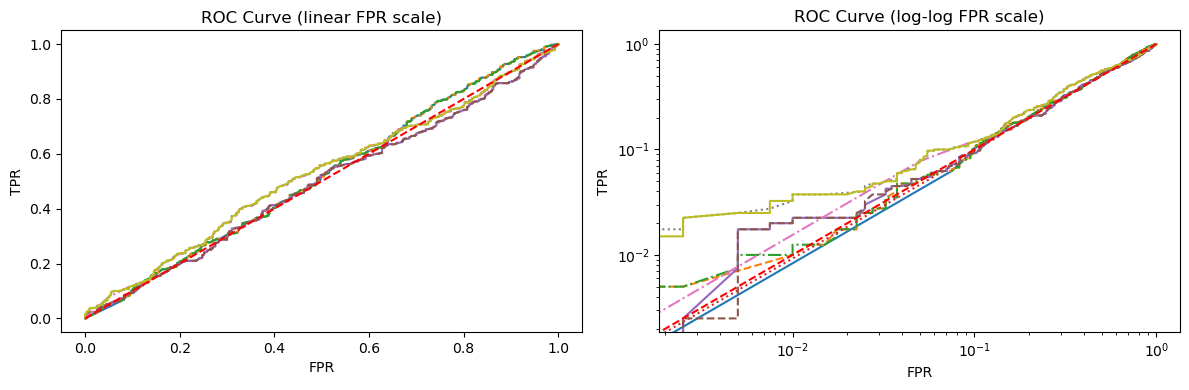

In [28]:
def plot_results(results, labels=None, smarts=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for ax, flag in zip(axs, [True, False]):
        for i, (fpr_vals, tpr_vals) in enumerate(results):
            label = None if labels is None else labels[i]
            smart = '-' if smarts is None else smarts[i]
            if flag:
                ax.plot(fpr_vals, tpr_vals, smart, label=label)
            else:
                ax.loglog(fpr_vals, tpr_vals, smart, label=label)

        ax.plot([0, 1], [0, 1], 'r--', label='random')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        title = 'ROC Curve (linear FPR scale)' if flag else 'ROC Curve (log-log FPR scale)'
        ax.set_title(title)
        #if labels is not None:
        #    ax.legend()
    plt.tight_layout()

plot_results(results, labels=labels, smarts=smarts)


2025-10-07 12:42:52,356 INFO     Configuring the modular RMIA attack
2025-10-07 12:42:52,357 INFO     Audit logits bundle provided; skipping model evaluations for audit data
2025-10-07 12:42:52,357 INFO     Auxiliary logits bundle provided; skipping shadow model evaluations for reference data
2025-10-07 12:42:52,357 INFO     Preparing RMIA attack inputs
2025-10-07 12:42:52,362 INFO     Configuring the modular RMIA attack
2025-10-07 12:42:52,362 INFO     Audit logits bundle provided; skipping model evaluations for audit data
2025-10-07 12:42:52,363 INFO     Auxiliary logits bundle provided; skipping shadow model evaluations for reference data
2025-10-07 12:42:52,363 INFO     Preparing RMIA attack inputs


vectorized_time=0.006s, loop_time=0.004s


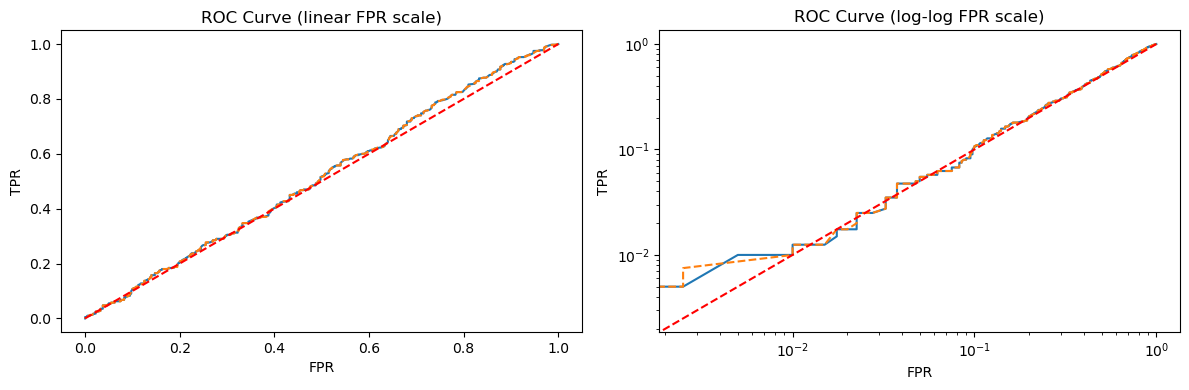

In [29]:
import time

start_vec = time.time()
vectorized_scores, vectorized_membership, _ = run_modular_offline_attack(
    audit_bundles[0],
    aux_bundle,
    gamma=1.2,
    vectorized=True,
)
vec_time = time.time() - start_vec

start_loop = time.time()
looped_scores, looped_membership, _ = run_modular_offline_attack(
    audit_bundles[0],
    aux_bundle,
    gamma=1.2,
    vectorized=False,
)
loop_time = time.time() - start_loop

vec_fpr, vec_tpr, _ = rmia_roc(vectorized_scores, vectorized_membership)
loop_fpr, loop_tpr, _ = rmia_roc(looped_scores, looped_membership)
print(f'vectorized_time={vec_time:.3f}s, loop_time={loop_time:.3f}s')
plot_results([(vec_fpr, vec_tpr), (loop_fpr, loop_tpr)], labels=['vectorized', 'looped'], smarts=['-', '--'])


## Optional: train lightweight models on CIFAR-10
Set `ENABLE_CIFAR_TRAINING = True` below to download CIFAR-10, train tiny CNNs for the target and shadow models,
and then run the vectorised RMIA scoring on the resulting logits. By default training is disabled so the notebook
still runs quickly with synthetic bundles.

In [30]:
ENABLE_CIFAR_TRAINING = True  # Flip to True to train models
NUM_REAL_SHADOWS = 2
TARGET_TRAIN_SAMPLES = 2048
SHADOW_TRAIN_SAMPLES = 2048
AUDIT_IN_SAMPLES = 512
AUDIT_OUT_SAMPLES = 512
AUX_SAMPLES = 2048
REAL_BATCH_SIZE = 128
REAL_EPOCHS = 3
REAL_TEMPERATURE = 2.0
SEED_REAL = 17


In [31]:
if ENABLE_CIFAR_TRAINING:
    import numpy as np
    import torch
    from torch import nn, optim
    from torch.utils.data import DataLoader, TensorDataset
    from torchvision import datasets, transforms

    rng_real = np.random.default_rng(SEED_REAL)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    cifar_train = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    cifar_test = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

    train_indices = rng_real.choice(len(cifar_train), size=TARGET_TRAIN_SAMPLES + AUX_SAMPLES + SHADOW_TRAIN_SAMPLES * NUM_REAL_SHADOWS, replace=False)
    target_train_idx = train_indices[:TARGET_TRAIN_SAMPLES]
    aux_idx = train_indices[TARGET_TRAIN_SAMPLES:TARGET_TRAIN_SAMPLES + AUX_SAMPLES]
    remaining = train_indices[TARGET_TRAIN_SAMPLES + AUX_SAMPLES:]
    shadow_train_indices = [remaining[i * SHADOW_TRAIN_SAMPLES:(i + 1) * SHADOW_TRAIN_SAMPLES] for i in range(NUM_REAL_SHADOWS)]
    audit_in_idx = target_train_idx[:AUDIT_IN_SAMPLES]
    audit_out_idx = rng_real.choice(len(cifar_test), size=AUDIT_OUT_SAMPLES, replace=False)

    def tensor_from_indices(dataset, indices):
        xs, ys = [], []
        for idx in indices:
            x, y = dataset[idx]
            xs.append(x)
            ys.append(y)
        return torch.stack(xs), torch.tensor(ys)

    audit_in_x, audit_in_y = tensor_from_indices(cifar_train, audit_in_idx)
    audit_out_x, audit_out_y = tensor_from_indices(cifar_test, audit_out_idx)
    audit_x = torch.cat([audit_in_x, audit_out_x], dim=0)
    audit_y = torch.cat([audit_in_y, audit_out_y], dim=0)
    audit_membership = np.zeros(len(audit_y), dtype=bool)
    audit_membership[:AUDIT_IN_SAMPLES] = True
    audit_loader = DataLoader(TensorDataset(audit_x, audit_y), batch_size=REAL_BATCH_SIZE, shuffle=False)

    aux_x, aux_y = tensor_from_indices(cifar_train, aux_idx)
    aux_loader = DataLoader(TensorDataset(aux_x, aux_y), batch_size=REAL_BATCH_SIZE, shuffle=False)

    target_train_loader = DataLoader(TensorDataset(*tensor_from_indices(cifar_train, target_train_idx)), batch_size=REAL_BATCH_SIZE, shuffle=True)
    shadow_loaders = [DataLoader(TensorDataset(*tensor_from_indices(cifar_train, idxs)), batch_size=REAL_BATCH_SIZE, shuffle=True) for idxs in shadow_train_indices]

    class SmallCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64 * 8 * 8, 256),
                nn.ReLU(),
                nn.Linear(256, 10),
            )

        def forward(self, x):
            return self.classifier(self.features(x))

    def train_model(model, loader):
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optim_fn = optim.Adam(model.parameters(), lr=1e-3)
        model.train()
        for _ in range(REAL_EPOCHS):
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                optim_fn.zero_grad()
                logits = model(imgs)
                loss = criterion(logits, labels)
                loss.backward()
                optim_fn.step()
        model.eval()
        return model.cpu()

    def gather_logits(model, loader):
        model.to(device)
        model.eval()
        out_logits, out_labels = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                logits = model(imgs).cpu().numpy()
                out_logits.append(logits)
                out_labels.append(labels.numpy())
        model.cpu()
        return np.concatenate(out_logits, axis=0), np.concatenate(out_labels, axis=0)

    def correct_class_probs(logits, labels, temperature=1.0):
        scaled = logits / temperature
        scaled -= scaled.max(axis=1, keepdims=True)
        exp = np.exp(scaled)
        probs = exp / exp.sum(axis=1, keepdims=True)
        return probs[np.arange(len(labels)), labels]

    target_model = train_model(SmallCNN(), target_train_loader)
    audit_logits_target, audit_labels = gather_logits(target_model, audit_loader)
    aux_logits_target, aux_labels = gather_logits(target_model, aux_loader)

    shadow_audit_probs = []
    shadow_aux_probs = []
    for loader in shadow_loaders:
        shadow_model = train_model(SmallCNN(), loader)
        audit_logits_shadow, _ = gather_logits(shadow_model, audit_loader)
        aux_logits_shadow, _ = gather_logits(shadow_model, aux_loader)
        shadow_audit_probs.append(correct_class_probs(audit_logits_shadow, audit_labels, REAL_TEMPERATURE))
        shadow_aux_probs.append(correct_class_probs(aux_logits_shadow, aux_labels, REAL_TEMPERATURE))

    target_audit_probs = correct_class_probs(audit_logits_target, audit_labels, REAL_TEMPERATURE)
    target_aux_probs = correct_class_probs(aux_logits_target, aux_labels, REAL_TEMPERATURE)

    real_audit_bundle = RMIAEvaluationBundle(
        target_probs=target_audit_probs,
        shadow_probs=np.stack(shadow_audit_probs, axis=1),
        shadow_inmask=np.zeros((len(audit_labels), NUM_REAL_SHADOWS), dtype=bool),
        target_inmask=audit_membership,
    )
    real_aux_bundle = RMIAEvaluationBundle(
        target_probs=target_aux_probs,
        shadow_probs=np.stack(shadow_aux_probs, axis=1),
        shadow_inmask=np.zeros((len(aux_labels), NUM_REAL_SHADOWS), dtype=bool),
    )
else:
    real_audit_bundle = None
    real_aux_bundle = None
    print('CIFAR-10 training disabled; skipping real-model demo.')


Files already downloaded and verified
Files already downloaded and verified


### Real Data Timing & ROC
Compare vectorised vs. looped runtimes and ROC curves using the trained CIFAR-10 models.

2025-10-07 12:43:25,316 INFO     Configuring the modular RMIA attack
2025-10-07 12:43:25,317 INFO     Audit logits bundle provided; skipping model evaluations for audit data
2025-10-07 12:43:25,323 INFO     Auxiliary logits bundle provided; skipping shadow model evaluations for reference data
2025-10-07 12:43:25,324 INFO     Preparing RMIA attack inputs
2025-10-07 12:43:25,340 INFO     Configuring the modular RMIA attack
2025-10-07 12:43:25,340 INFO     Audit logits bundle provided; skipping model evaluations for audit data
2025-10-07 12:43:25,341 INFO     Auxiliary logits bundle provided; skipping shadow model evaluations for reference data
2025-10-07 12:43:25,341 INFO     Preparing RMIA attack inputs


vectorized_time=0.024s, loop_time=0.012s


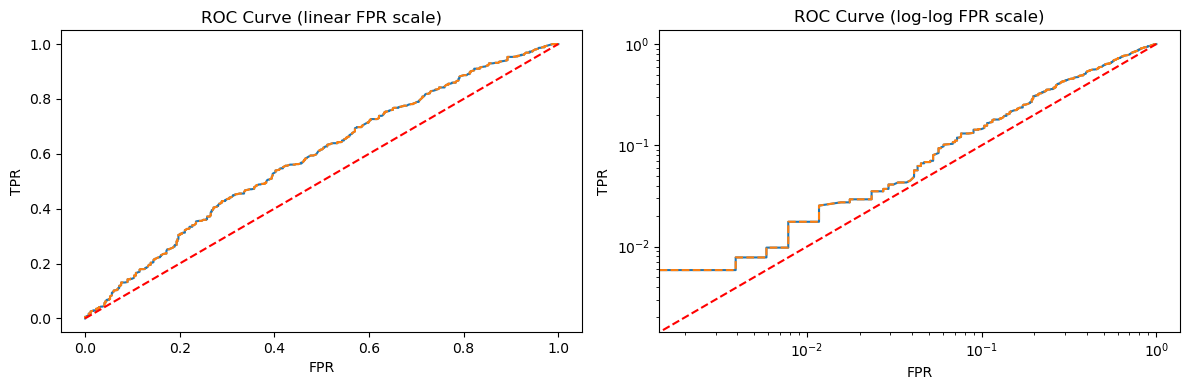

In [32]:
if real_audit_bundle is not None and real_aux_bundle is not None:
    import time
    start_vec = time.time()
    real_scores_vec, real_membership_vec, _ = run_modular_offline_attack(
        real_audit_bundle,
        real_aux_bundle,
        gamma=1.5,
        vectorized=True,
    )
    vec_time = time.time() - start_vec

    start_loop = time.time()
    real_scores_loop, real_membership_loop, _ = run_modular_offline_attack(
        real_audit_bundle,
        real_aux_bundle,
        gamma=1.5,
        vectorized=False,
    )
    loop_time = time.time() - start_loop

    vec_fpr, vec_tpr, _ = rmia_roc(real_scores_vec, real_membership_vec)
    loop_fpr, loop_tpr, _ = rmia_roc(real_scores_loop, real_membership_loop)
    print(f'vectorized_time={vec_time:.3f}s, loop_time={loop_time:.3f}s')
    plot_results([(vec_fpr, vec_tpr), (loop_fpr, loop_tpr)], labels=['vectorized', 'looped'], smarts=['-', '--'])
else:
    print('Run the training cell above to enable real-data evaluation.')
